In [4]:
library(arrow)
library(readxl)
library(showtext)
library(tidyverse)

source("datasets.r")

options(
  lubridate.week.start = 1,
  readr.show_col_types = FALSE
)

font_add(
  family = "Roboto Condensed",
  regular = "RobotoCondensed-Regular.ttf",
  bold = "RobotoCondensed-Bold.ttf"
)
showtext_auto()

theme_set(
  hrbrthemes::theme_ipsum_rc(
    axis_title_size = 12,
    base_size = 12,
    grid = "XY"
  )
)

colour_solar <- "#f2b130"
colour_solar_light <- "#f4e5c7"
colour_wind <- "dodgerblue"

# Historical installed capacities for use with the ENTSO-E data.
df_installed_entsoe <- tribble(
  ~ Source, ~ Year, ~ InstalledMW,
  "Onshore", 2015, 278,
  "Onshore", 2016, 282,
  "Onshore", 2017, 308,
  "Onshore", 2018, 317,
  "Onshore", 2019, 339,
  "Onshore", 2020, 339,
  "Onshore", 2021, 339,
  "Onshore", 2022, 339,
  "Onshore", 2023, 343,
  "Solar", 2015, 2078,
  "Solar", 2016, 2076,
  "Solar", 2017, 2077,
  "Solar", 2018, 2062,
  "Solar", 2019, 2069,
  "Solar", 2020, 2080,
  "Solar", 2021, 2088,
  "Solar", 2022, 2082,
  "Solar", 2023, 2800  # Approximately.
)

zone_to_country_code <- \(zone) substr(zone, 1, 2)

load_pemmdb_capacities <- \(target_year) {
  data_file_path("ERAA2023 PEMMDB Generation.xlsx") |>
  read_xlsx(
    sheet = str_glue("TY{target_year}"),
    range = "B2:BE25"
  ) |>
    rename(Source = 1) |>
    filter(Source %in% c("Solar (Photovoltaic)", "Wind Offshore", "Wind Onshore")) |>
    mutate(
      Source = case_match(
        Source,
        "Solar (Photovoltaic)" ~ "Solar",
        "Wind Offshore" ~ "Offshore",
        "Wind Onshore" ~ "Onshore"
      )
    ) |>
    pivot_longer(!Source, names_to = "Zone", values_to = "CapacityMW") |>
    filter(CapacityMW > 0) |>
    group_by(
      Source,
      Country = zone_to_country_code(Zone)
    ) |>
    summarise(CapacityMW = sum(CapacityMW), .groups = "drop")
}

# Projected installed capacities from ERAA data for use
# with the PECD time series.
df_installed_pecd <- load_pemmdb_capacities(target_year = 2025)


## Data loading


### Historical data from ENTSO-E

Load historical generation and demand time series from the ENTSO-E Transparency Platform and rescale generation to capacity factors.


In [5]:
cz_entsoe <- (2015:2023) |>
  map(
    ~ load_dataset_entsoe("CZ", .x) |>
        select(Date, Demand = Load, Nuclear, Onshore, Solar) |>
        mutate(
          # There are a couple of hours with zero load, replace those with linear
          # approximation (the mean of the two neighbouring hours if there's only
          # one missing).
          across(Demand, ~ if_else(Demand == 0, NA, Demand) |> zoo::na.approx(maxgap = 2))
        )
  ) |>
  list_rbind() |>
  mutate(
    Year = year(Date),
    Month = month(Date)
  ) |>
  left_join(
    pivot_wider(
      df_installed_entsoe,
      names_from = Source,
      names_prefix = "Installed",
      values_from = InstalledMW
    ),
    join_by(Year)
  ) |>
  mutate(
    Nuclear = Nuclear / 4047,
    Onshore = Onshore / InstalledOnshore,
    Solar = Solar / InstalledSolar
  ) |>
  select(!starts_with("Installed"))

num_years <- length(unique(cz_entsoe$Year))


### Simulated data from PECD

Load simulated generation and demand time series from the Pan-European Climate Database (PECD).


In [6]:
# Multiply capacity factors by assumed installed capacities in the target
# year from the "PEMMDB Generation" spreadsheet.
df_europe_offshore <- data_file_path("PECD-ERAA2023-Wind_Offshore-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Offshore"),
    join_by(country == Country)
  ) |>
  summarise(
    Offshore = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour)

df_europe_onshore <- data_file_path("PECD-ERAA2023-Wind_Onshore-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Onshore"),
    join_by(country == Country)
  ) |>
  summarise(
    Onshore = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour)

df_europe_daily_wind <- inner_join(
    df_europe_offshore |> summarise(across(Offshore, sum), .by = year:day),
    df_europe_onshore |> summarise(across(Onshore, sum), .by = year:day),
    join_by(year, month, day)
  ) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    Wind = (Offshore + Onshore) / 1e3
  )

df_europe_daily_solar <- data_file_path("PECD-ERAA2023-LFSolarPV-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Solar"),
    join_by(country == Country)
  ) |>
  summarise(
    Solar = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour) |>
  summarise(across(Solar, sum), .by = year:day) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    Solar = Solar / 1e3
  )


## Charts


### Solar PV – distribution \& surpluses, extrapolated historical data

First, a bit of data preparation, scaling and so on.


In [7]:
demand_factor <- 1.6
nuclear_installed_gw <- 5
solar_installed_gw <- seq(10, 40, 5)
wind_installed_gw <- 15

df_solar_used <- solar_installed_gw |>
  map(
    ~ cz_entsoe |>
        mutate(
          Demand = demand_factor * Demand,
          Nuclear = nuclear_installed_gw * 1000 * Nuclear,
          Onshore = wind_installed_gw * 1000 * Onshore,
          Solar = .x * 1000 * Solar,
          Residual = Demand - Nuclear - Onshore - Solar,
          SurplusSolar = pmax(0, -Residual * Solar / (Onshore + Solar))
        ) |>
        summarise(
          SolarInstalledGW = .x,
          TotalSolar = sum(Solar) / 1e6,
          SurplusSolar = sum(SurplusSolar, na.rm = TRUE) / 1e6,
          .by = Year
        )
  ) |>
  list_rbind()

# Distribution of surplus production.
df_solar_surpluses <- cz_entsoe |>
  mutate(
    Demand = demand_factor * Demand,
    Nuclear = nuclear_installed_gw * 1000 * Nuclear,
    Onshore = wind_installed_gw * 1000 * Onshore,
    Solar = 25 * 1000 * Solar,
    Residual = Demand - Nuclear - Onshore - Solar,
    SurplusTotal = pmax(0, -Residual),
    SurplusSolar = SurplusTotal * Solar / (Onshore + Solar),
  )


Now for the distribution of surpluses as a a) histogram, b) CDF, and c) duration curve.


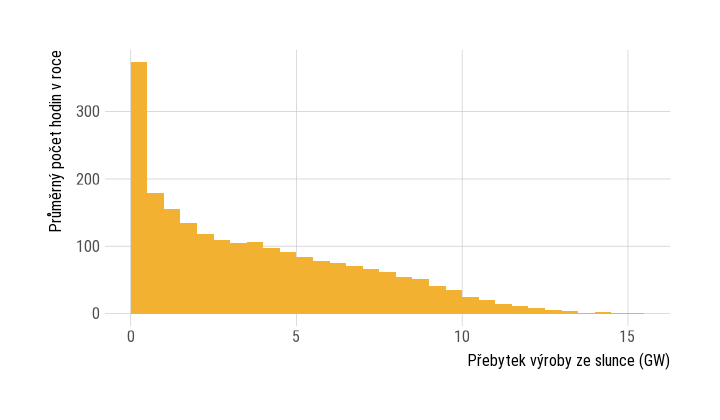

In [8]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# a. Histogram.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3, after_stat(count) / num_years)) +
  geom_histogram(
    fill = colour_solar,
    binwidth = .5,
    boundary = 0
  ) +
  labs(
    x = "Přebytek výroby ze slunce (GW)",
    y = "Průměrný počet hodin v roce"
  )


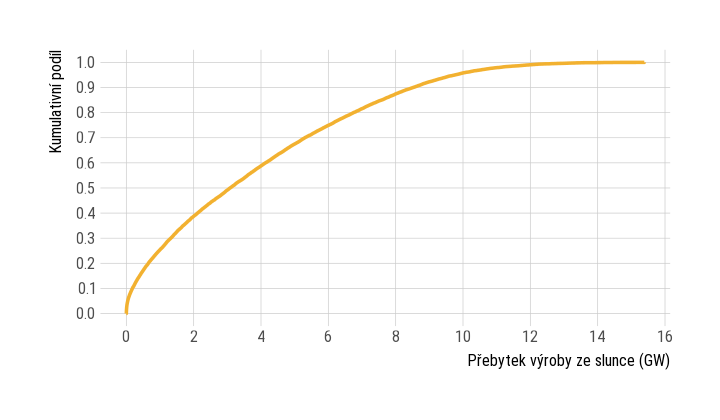

In [9]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# b. CDF.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3)) +
  stat_ecdf(
    colour = colour_solar,
    linewidth = 1,
    pad = FALSE
  ) +
  scale_x_continuous("Přebytek výroby ze slunce (GW)", breaks = seq(0, 20, 2)) +
  scale_y_continuous("Kumulativní podíl", breaks = seq(0, 1, .1))


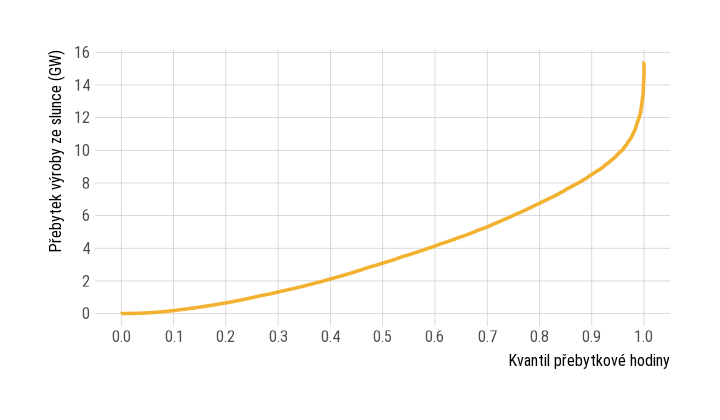

In [10]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# c. Duration curve.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3)) +
  stat_ecdf(
    colour = colour_solar,
    linewidth = 1,
    pad = FALSE
  ) +
  scale_x_continuous(breaks = seq(0, 20, 2)) +
  scale_y_continuous(breaks = seq(0, 1, .1)) +
  coord_flip() +
  labs(
    x = "Přebytek výroby ze slunce (GW)",
    y = "Kvantil přebytkové hodiny"
  )


The following show the correlation of solar production and total surplus production. It is mainly solar that causes surplus production.


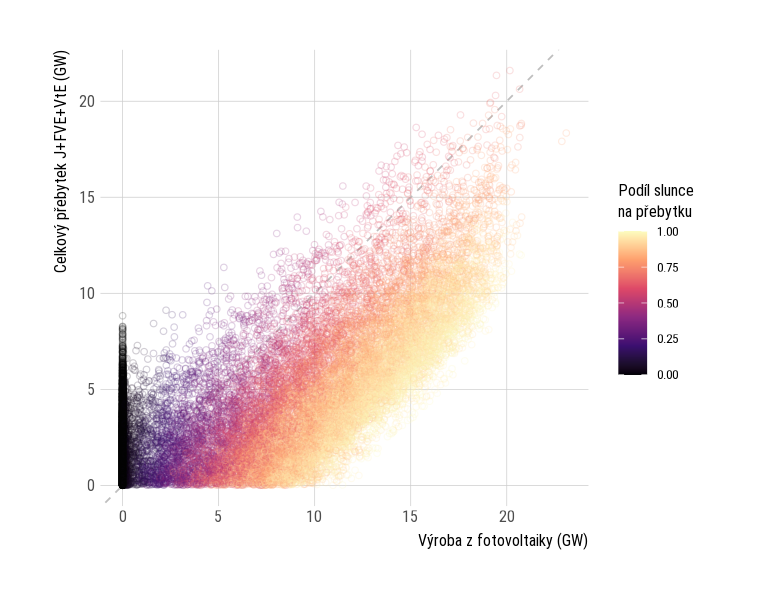

In [11]:
options(repr.plot.height = 5, repr.plot.width = 6.5)

df_solar_surpluses |>
  mutate(SurplusTotal = pmax(0, -Residual)) |>
  filter(SurplusTotal > 0) |>
  ggplot(aes(Solar / 1e3, SurplusTotal / 1e3)) +
  geom_abline(slope = 1, colour = "grey", linetype = "dashed") +
  geom_point(
    aes(colour = Solar / (Solar + Onshore)),
    shape = 1,
    alpha = .2
  ) +
  scale_colour_viridis_c(
    "Podíl slunce\nna přebytku",
    option = "magma",
    limits = c(0, 1)
  ) +
  coord_fixed() +
  labs(
    x = "Výroba z fotovoltaiky (GW)",
    y = "Celkový přebytek J+FVE+VtE (GW)"
  )


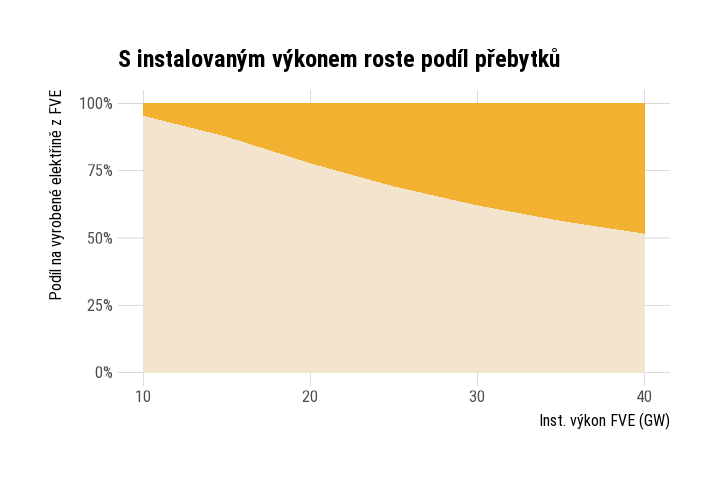

In [12]:
options(repr.plot.height = 4, repr.plot.width = 6)

df_solar_used |>
  summarise(
    Surplus = mean(SurplusSolar),
    Used = mean(TotalSolar - SurplusSolar),
    .by = SolarInstalledGW
  ) |>
  pivot_longer(
    !SolarInstalledGW,
    names_to = "Category",
    values_to = "Volume"
  ) |>
  ggplot(aes(SolarInstalledGW, Volume)) +
  geom_area(aes(fill = Category), position = "fill") +
  scale_y_continuous(
    "Podíl na vyrobené elektřině z FVE",
    labels = scales::label_percent()
  ) +
  scale_fill_manual(
    guide = "none",
    values = c(Surplus = colour_solar, Used = "#f3e5cd")
  ) +
  labs(
    title = "S instalovaným výkonem roste podíl přebytků",
    x = "Inst. výkon FVE (GW)"
  ) +
  expand_limits(y = 0)


### Solar PV – Czechia, historical

These charts are limited to the period between April and September (inclusive).


In [13]:
df_solar_cz_daily <- cz_entsoe |>
  mutate(
    Date = as_date(Date),
    # Capacity factor to GWh.
    Solar = 25 * Solar
  ) |>
  summarise(across(Solar, sum), .by = Date) |>
  mutate(
    DayOfYear = yday(Date),
    Year = year(Date),
    Month = month(Date)
  )

scales_solar_cz_daily <- function() {
  list(
    scale_x_continuous(
      "Den v roce",
      breaks = cumsum(c(91, 30, 31, 30, 31, 31, 30)),
      labels = c("duben", "květen", "červen", "červenec", "srpen", "září", "říjen"),
      expand = expansion(mult = .02)
    ),
    scale_y_continuous("Výroba z fotovoltaiky (GWh za den)", limits = c(0, 180))
  )
}


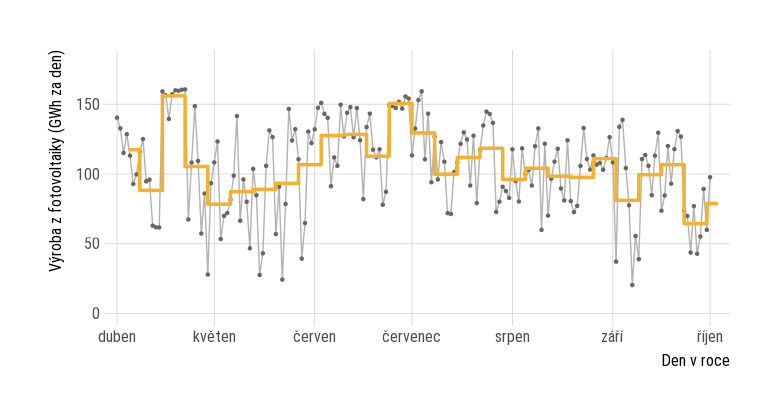

In [14]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_solar_cz_daily |>
  filter(Year == 2019) |>
  filter(between(DayOfYear, 91, 274)) |>
  ggplot(aes(DayOfYear, Solar)) +
  geom_line(colour = "grey70", linewidth = .4) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_solar,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_solar_cz_daily()


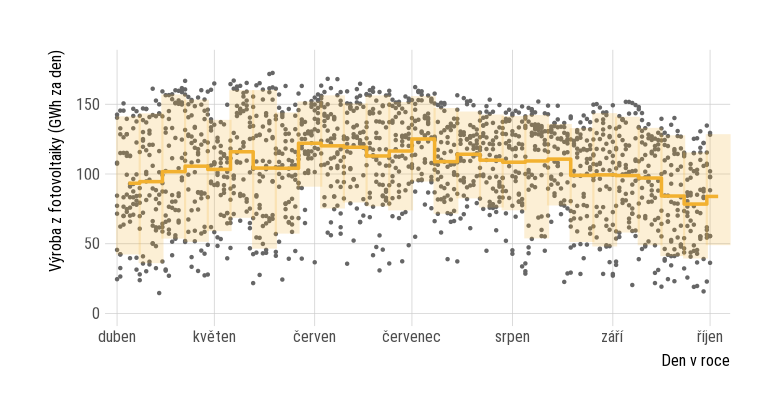

In [15]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_solar_cz_daily |>
  filter(between(DayOfYear, 91, 274)) |>
  ggplot(aes(DayOfYear, Solar)) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "linerange",
    binwidth = 7,
    colour = colour_solar,
    alpha = .2,
    linewidth = 7,
    fun.max = ~ quantile(.x, .9),
    fun.min = ~ quantile(.x, .1)
  ) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_solar,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_solar_cz_daily()


### Solar PV – Europe, simulated


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


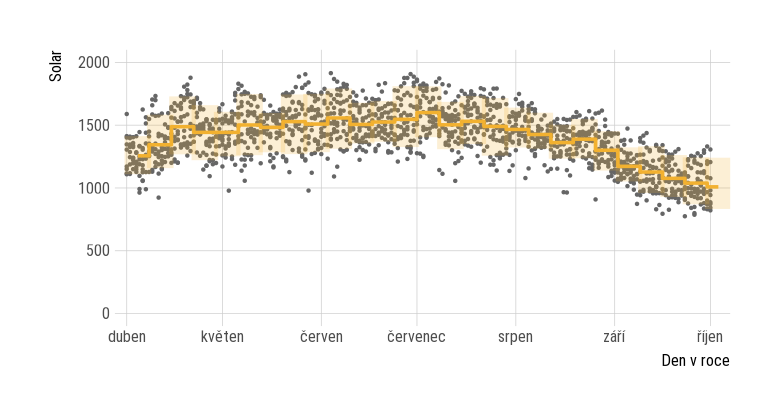

In [16]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_europe_daily_solar |>
  filter(
    between(Year, 2011, 2011 + num_years - 1),
    between(DayOfYear, 91, 274)
  ) |>
  ggplot(aes(DayOfYear, Solar)) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "linerange",
    binwidth = 7,
    colour = colour_solar,
    alpha = .2,
    linewidth = 7.5,
    fun.max = ~ quantile(.x, .9),
    fun.min = ~ quantile(.x, .1)
  ) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_solar,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_solar_cz_daily() +
  ylim(0, 2000)


### Wind – Czechia, historical


In [17]:
df_wind_cz_daily <- cz_entsoe |>
  mutate(
    Date = as_date(Date),
    # Capacity factor to GWh.
    # NOTE: Using current (end of 2023) capacity.
    Onshore = .343 * Onshore
  ) |>
  summarise(across(Onshore, sum), .by = Date) |>
  mutate(
    DayOfYear = if_else(
      month(Date) <= 6,
      365 + yday(Date),
      yday(Date)
    ),
    Year = year(Date)
  )

scales_wind_cz_daily <- function(ylim = c(0, 7.5)) {
  list(
    scale_x_continuous(
      "Den v roce",
      breaks = cumsum(c(274, 31, 30, 31, 31, 29, 31)),
      labels = c("říjen", "listopad", "prosinec", "leden", "únor", "březen", "duben"),
      expand = expansion(mult = .02)
    ),
    scale_y_continuous("Výroba z větru (GWh za den)", limits = ylim)
  )
}


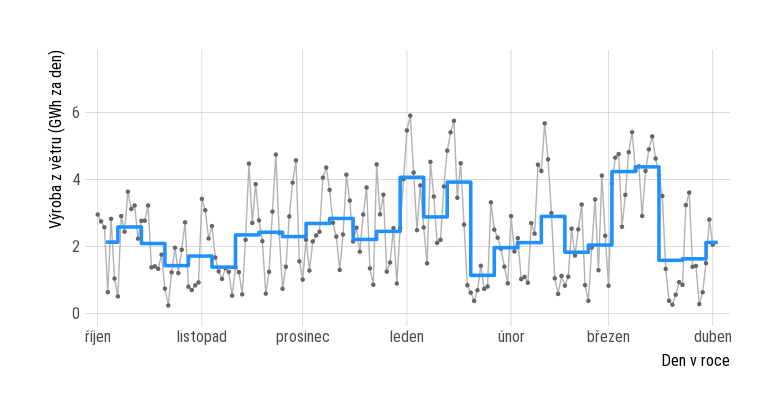

In [18]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_wind_cz_daily |>
  filter(
    Year == 2019,
    between(DayOfYear, 274, 457)
  ) |>
  ggplot(aes(DayOfYear, Onshore)) +
  geom_line(colour = "grey70", linewidth = .4) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_wind,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_wind_cz_daily()


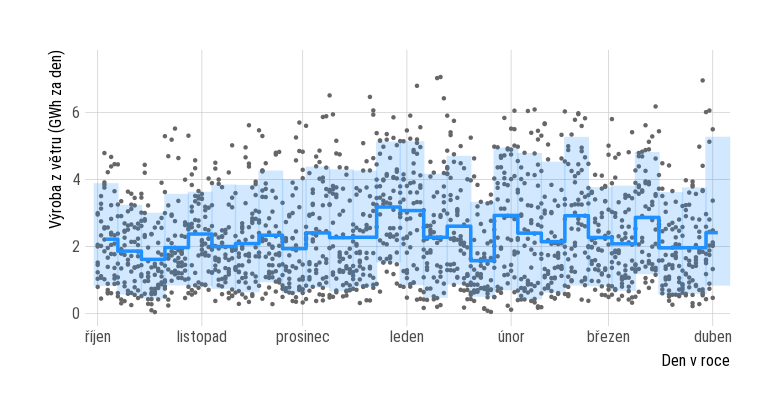

In [19]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_wind_cz_daily |>
  filter(between(DayOfYear, 274, 457)) |>
  ggplot(aes(DayOfYear, Onshore)) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "linerange",
    binwidth = 7,
    colour = colour_wind,
    linewidth = 7,
    alpha = .2,
    fun.max = ~ quantile(.x, .9),
    fun.min = ~ quantile(.x, .1)
  ) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_wind,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_wind_cz_daily()


### Wind – simulated


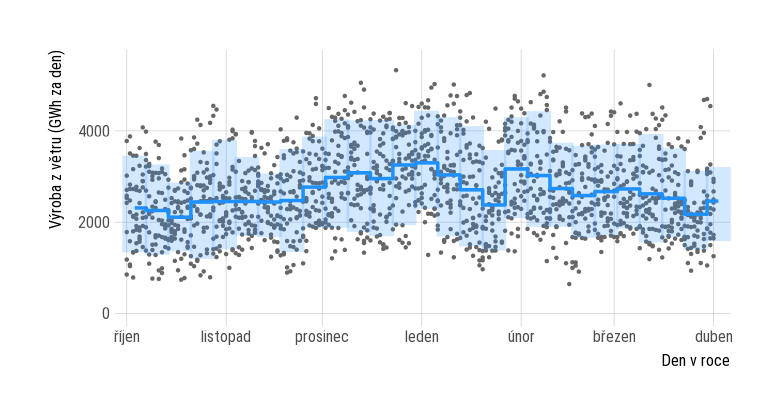

In [20]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_europe_daily_wind |>
  mutate(
    DayOfYear = if_else(
      Month <= 6,
      365 + DayOfYear,
      DayOfYear
    )
  ) |>
  filter(
    between(Year, 2011, 2011 + num_years - 1),
    between(DayOfYear, 274, 457)
  ) |>
  ggplot(aes(DayOfYear, Wind)) +
  geom_point(colour = "grey40", size = .6) +
  stat_summary_bin(
    geom = "linerange",
    binwidth = 7,
    colour = colour_wind,
    linewidth = 7,
    alpha = .2,
    fun.max = ~ quantile(.x, .9),
    fun.min = ~ quantile(.x, .1)
  ) +
  stat_summary_bin(
    geom = "step",
    binwidth = 7,
    colour = colour_wind,
    linewidth = 1,
    direction = "mid",
    fun = mean
  ) +
  scales_wind_cz_daily(ylim = c(0, 5500))
